In [2]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import squarify 
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import re


In [3]:
# II- Download the reference tables
lands = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/ldown_c.csv')
countries_ref = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/countries_ref.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# III Merging the dfs
# It's neccessary to merge the databases of lands(lands types) and world (geographic reference), 
# using countries_ref as a reference table, to obtain the main df with all the necessary data.

##########################################################
# The study is done just whith the data of the 2016 year #
##########################################################
lands = lands[lands.year==2016]

# Merge the three tables:
l_c = countries_ref.merge(lands,left_on='name_l', right_on='country')
w_l_c = world.merge(l_c,
                    left_on = world['name'].str.strip().str.lower(), 
                    right_on=l_c['name_w'].str.strip().str.lower()).drop(columns=['name', 'key_0'], axis=1)


# Replace the string of types in order of simplify their names
lrep = {'Land area (thousand hectares)':'LA',
        'Arable land (thousand hectares)': 'AL', 'Arable land (% of total land area)':'AL_%',
        'Forest cover (thousand hectares)':'FC', 'Forest cover (% of total land area)':'FC_%',
        'Permanent crops (thousand hectares)':'PC','Permanent crops (% of total land area)':'PC_%',
        'Important sites for terrestrial biodiversity protected (% of total sites protected)':'IB%'}

# Final df with al the data            
w_l_c['type'] = w_l_c['type'].map(lrep)


In [102]:
# Create the indicators for the plots

#  ACA ES POSIBLE CREAR UN FUNCION PARA CREAR LOS df CON LOS INDICARES:
# CL, CL(AL + PC), 'pop_est%', 'density' and 'density_CL', LpL, ref, ind


al = w_l_c[['name_l','pop_est','value', 'geometry']][w_l_c['type']=='AL'].reset_index(drop=True)
pc = w_l_c[['value']][w_l_c['type']=='PC'].reset_index(drop=True)
la = w_l_c[['value']][w_l_c['type']=='LA'].reset_index(drop=True)
 

al = al.rename(columns={'value':'value_AL'})
pc = pc.rename(columns={'value':'value_PC'})
la = la.rename(columns={'value':'value_LA'})

o = pd.concat([al, pc, la], axis=1, join='inner')

print(o.shape)
print(o.head())
#print(al.head(10), pc.head(10))
#print(pc.head())

(172, 6)
                     name_l    pop_est  value_AL  \
0                      fiji     920938     165.0   
1   united rep. of tanzania   53950935   13500.0   
2            western sahara     603253       4.0   
3                    canada   35623680   43766.0   
4  united states of america  326625791  152263.0   

                                            geometry  value_PC  value_LA  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...      85.0    1827.0  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    2150.0   88580.0  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...       NaN   26600.0  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...    4644.0  909351.0  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...    2600.0  914742.0  


In [40]:
# VI

############################################################################
# Making the main indicators with Arable Lands, Permanent Crops and Lands: #
############################################################################

# CL- Cultivable lands
# #llist = ['Land area (thousand hectares)','Arable land (thousand hectares)','Permanent crops (thousand hectares)'] 
# llist = ['LA','AL','PC'] 

# # print(lterms)
# # ['Total Land Area (TLA)', 'Arable land (AL)', 
# #  'Permanent crops (PC)', 'Forest cover (FC)', 
# #  'Important sites for\n terrestrial biodiversity\n protected (IB)']


# dcl = landun_m[['name_w', 'type','value']][landun_m['type'].isin(llist)]
# dcl = dcl.groupby(['type','name_w']).sum()
# dcl = dcl.reset_index(level=['type'])
# dcl = dcl.pivot(columns='type', values='value')

# dcl['CL'] = dcl['AL']+dcl['PC']
# dcl['CL%'] = 100*dcl['CL']/dcl['LA']

# dcl = dcl.reset_index(level='name_w')

# # Are territors not a country, that's why i took it out
# dcl = dcl[~dcl['name_w'].str.contains('falkland is.|n. cyprus')] 

# # Linking the Lands tables with the world (geopandas) one
# dclw = world_m.merge(dcl, on='name_w', how='inner')

# # Percentage of Population Indicator (pop_est%) and density according the Cultivable Lands (density_CL)
# dclw['pop_est%'] = 100* dclw['pop_est']/dclw['pop_est'].sum()
# dclw['density'] = (dclw['pop_est']/4)/(0.1 + dclw['LA']*1000)
# dclw['density_CL'] = (dclw['pop_est']/4)/(0.1+dclw['CL']*1000)


# CL- Cultivable lands
dcl = w_l_c[['name_w', 'type','value']][w_l_c['type'].isin(['LA','AL','PC'])]
dcl = dcl.groupby(['type','name_w']).sum()
dcl = dcl.reset_index(level=['type'])
dcl = dcl.pivot(columns='type', values='value')
dcl['CL'] = dcl['AL']+dcl['PC']
dcl['CL%'] = 100*dcl['CL']/dcl['LA']
dcl = dcl.reset_index(level='name_w')

# Are territors not a country, that's why i took it out
dcl = dcl[~dcl['name_w'].str.contains('falkland is.|n. cyprus')] 

# Linking the Lands tables with the world (geopandas) one
dclw = world.merge(dcl, right_on='name_w', left_on=world['name'].str.strip().str.lower(), how='inner')
print(dclw.head())
# Percentage of Population Indicator (pop_est%) and density according the Cultivable Lands (density_CL)
dclw['pop_est%'] = 100* dclw['pop_est']/dclw['pop_est'].sum()
dclw['density'] = (dclw['pop_est']/4)/(0.1 + dclw['LA']*1000)
dclw['density_CL'] = (dclw['pop_est']/4)/(0.1+dclw['CL']*1000)



     pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2   35623680  North America                    Canada    CAN   1674000.0   
3  326625791  North America  United States of America    USA  18560000.0   
4   18556698           Asia                Kazakhstan    KAZ    460700.0   

                                            geometry  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
3  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   
4  POLYGON ((87.35997 49.21498, 86.59878 48.54918...   

                     name_w        AL        LA      PC        CL        CL%  
0                      fiji     165.0    1827.0    85.0     250.0  13.683634  
1                  tanzania   13500.0   88580.0 

/home/hmdg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/hmdg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/hmdg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



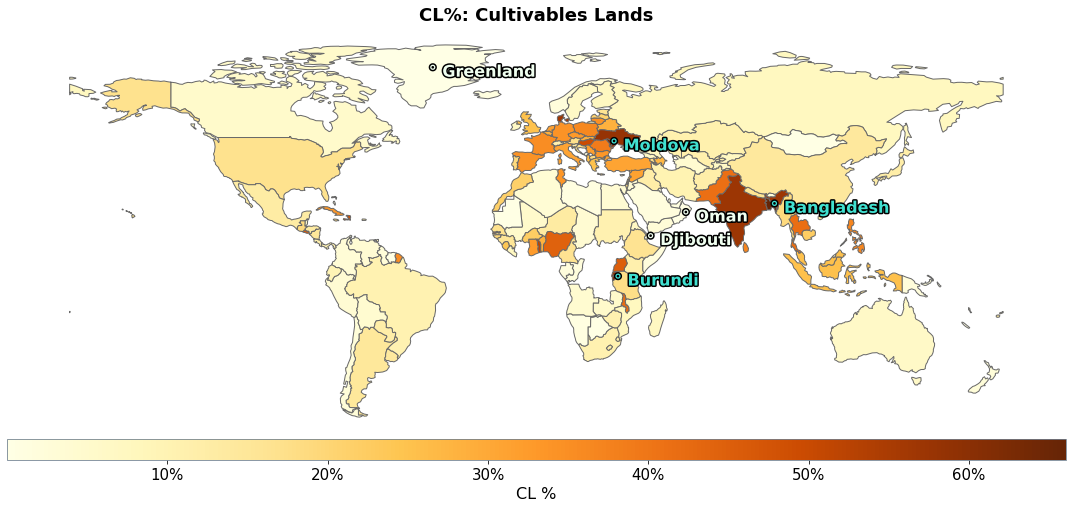

In [41]:
# VII
# ########## Un solo mapa 
%matplotlib inline
#%matplotlib notebook

# plt.style.use('seaborn-deep')#<'Solarize_Light2')
# Setting the rcParams
plt.rcParams.update({'xtick.labelsize':15, 
                     'ytick.labelsize':15,
                     'ytick.labelleft':'off',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False,
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     #'axes.ymargin': 0.5, 
                     #'axes.autolimit_mode': 'round_numbers',
                     'axes.labelsize':16,
                     'axes.grid':False,
                     'axes.edgecolor':'slategrey'
                    })

fig, ax1 = plt.subplots(1, 1, figsize=(15, 10))


divider = make_axes_locatable(ax1)

# Legend bar
cax = divider.append_axes("bottom", size="5%", pad=0.05)

# Plot
ax1 = dclw.plot(column='CL%',
                ax=ax1,
                legend=True,
                edgecolor='dimgray',#white',#dimgrey',
                cmap = 'YlOrBr',#'Greens',# OrRd-rojos',#'RdBu',#'GnBu',#'Wistia',
                cax=cax,
                legend_kwds={'label': "CL %",
                             'orientation': 'horizontal'}
               )

# Adding the percentage to the labels of the legend
s = cax.get_xticks()
labelc = []
[labelc.append(str(int(s[n]))+'%') for n in range(len(s))]
cax.set_xticklabels(labelc)


# Selecting the countries to show
small= ['greenland', 'djibouti', 'oman']
dclwmn = pd.concat([dclw.sort_values(by='CL%').tail(3), dclw[dclw['name_w'].isin(small)]]).reset_index(drop=True)
dclwmn = dclwmn.set_crs("EPSG:4326")



dclwmn['geops'] = gpd.GeoDataFrame(
    geometry = gpd.points_from_xy(dclwmn['geometry'].centroid.x, dclwmn['geometry'].centroid.y),
    crs = "EPSG:4326"
    )


# Adding the names of the selected countries
for place in range(dclwmn.shape[0]):
    if place < 3:
        color = 'turquoise' #'tan' #yellowgreen', #'darkolivegreen',#'forestgreen',#'darkslategray',#','dimgray',#
    else:
        color = 'honeydew'#lightgreen'#'tomato'#'orchid'#'coral'
    ax1.text(dclwmn.geops[place].x,
             dclwmn.geops[place].y-3,
             '\u00B0' + ' ' + dclwmn.loc[place,'name_w'].capitalize(),
             fontsize = 16,#'xx-large',
             fontweight = 'bold',
             color = color,
             path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
    

ax1.set_title('CL%: Cultivables Lands', fontsize=18, fontweight = 'bold')
# ax1.patch.set_facecolor('aliceblue')#lightgrey')
plt.tight_layout()

plt.savefig('/home/hmdg/Documents/Data_Science/Lands/CL.png', bbox_inches='tight')

plt.show()


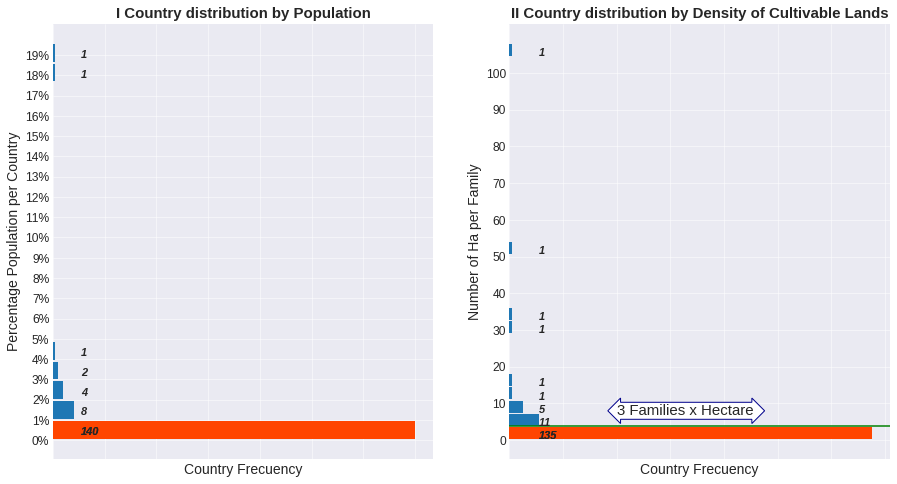

In [42]:
# IIX Histogram division

fig = plt.figure(figsize=(15,8))

plt.rcParams.update({'xtick.labelsize':12,  # plt.rcParams['xtick.labelsize']=14
                     'ytick.labelsize':12, # plt.rcParams['ytick.labelsize']=14
                     'ytick.labelleft':'on', # plt.rcParams['ytick.labelleft']=True
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,  # plt.rcParams['axes.spines.left'] =False
                     'axes.spines.bottom' : False, # plt.rcParams['axes.spines.bottom'] =False
                     'axes.spines.top': False, # plt.rcParams['axes.spines.top'] =False
                     'axes.spines.right':False, # plt.rcParams['axes.spines.right'] =False
                     'ytick.left':False, # plt.rcParams['ytick.left'] =False
                     'xtick.bottom':False, # plt.rcParams['xtick.bottom'] =False
                     'xtick.top': False, # plt.rcParams['xtick.top'] =False
                     'axes.labelsize':14,
                     'axes.edgecolor':'slategrey',
                     'grid.linewidth':0.5
                    })

plt.style.use('seaborn-darkgrid') #) # 'Solarize_Light2''seaborn-deep'


#### GRAPH 1 ####
ax3 = fig.add_subplot(1,2,1)

ax3.set_ylabel('Percentage Population per Country')
ax3.set_xlabel('Country Frecuency')
ax3.set_title('I Country distribution by Population', weight='bold', size=15)

a_bins = 20
ax3, bins, patches3 = plt.hist(dclw['pop_est%'],
                               bins= a_bins, orientation='horizontal', rwidth=0.9) #a_bins, , range=(0,20)
patches3[0].set_fc('orangered')
plt.yticks(np.arange(0, 20, 1))

# Y axe in percentaje
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

# # Adding the value of each bar (plot1)
high = 0.2
texto = lambda t: plt.text(11, high + t.xy[1], int(t.get_width()),size=11, 
                           fontweight='bold', fontstyle='oblique')
vfunc = np.vectorize(texto)

## Filter the 0 width columns (plot1)
p1 = [patches3[i] for i in range(len(patches3)) if patches3[i].get_width() > 0]
vfunc(p1)

#### GRAPH 2 ####
b_bins = 30
ax4 = fig.add_subplot(1,2,2)
ax4.set_ylabel('Number of Ha per Family') #Population Density')
ax4.set_xlabel('Country Frecuency')
ax4.set_title('II Country distribution by Density of Cultivable Lands', weight='bold', size=15)

ax4, bins, patches4 = plt.hist(dclw['density_CL'],  orientation='horizontal', bins= b_bins,
                            range= None, rwidth=0.9, bottom=0) 


plt.text(40, 3 + patches4[1].xy[1], str(int(patches4[1].xy[1]))+' Families x Hectare', fontsize=15 ,
         bbox=dict(boxstyle='darrow,pad=0.1', fc='white', ec='darkblue'))#square,pad=0.1

[patches4[n].set_fc('orangered') for n in range(len(patches4)) if patches4[n].xy[1] < 1]

# # Adding the value of each bar (plot2)
high = 0.02
p2 = [patches4[i] for i in range(len(patches4)) if patches4[i].get_width() > 0]
vfunc(p2)

plt.axhline(y=patches4[1].xy[1], color='green') # Adding the reference line
plt.yticks(np.arange(0, 110, 10)) # Changing the y steps
patches4[0].set_fc('orangered')

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/hist_dens.png')

plt.show()


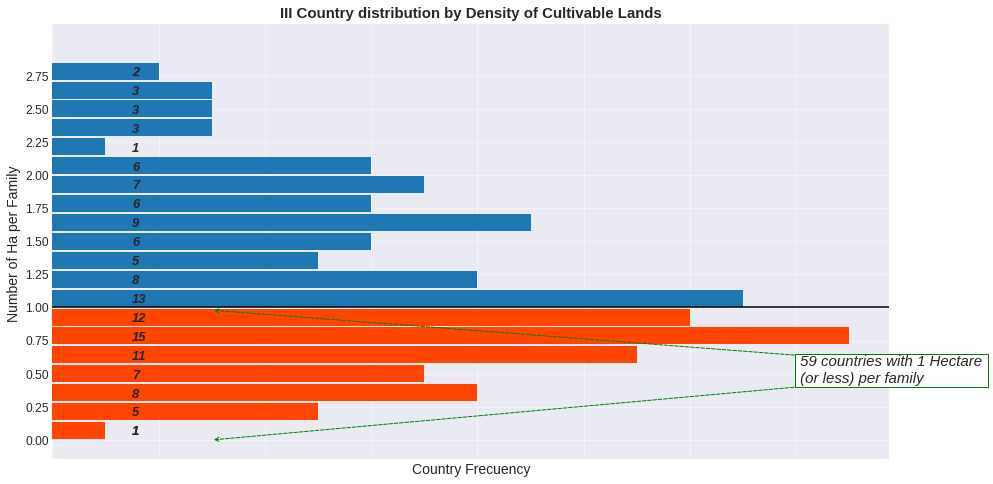

In [43]:
# IX Histogram 

fig = plt.figure(figsize=(15,8))

plt.rcParams.update({'xtick.labelsize':12,  # plt.rcParams['xtick.labelsize']=14
                     'ytick.labelsize':12, # plt.rcParams['ytick.labelsize']=14
                     'ytick.labelleft':'on', # plt.rcParams['ytick.labelleft']=True
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,  # plt.rcParams['axes.spines.left'] =False
                     'axes.spines.bottom' : False, # plt.rcParams['axes.spines.bottom'] =False
                     'axes.spines.top': False, # plt.rcParams['axes.spines.top'] =False
                     'axes.spines.right':False, # plt.rcParams['axes.spines.right'] =False
                     'ytick.left':False, # plt.rcParams['ytick.left'] =False
                     'xtick.bottom':False, # plt.rcParams['xtick.bottom'] =False
                     'xtick.top': False, # plt.rcParams['xtick.top'] =False
                     'axes.labelsize':14,
                     'axes.edgecolor':'slategrey',
                     'grid.linewidth':0.5
                    })

plt.style.use('seaborn-darkgrid') #) # 'Solarize_Light2''seaborn-deep'

### Graph 5

a_bins = 21
ax5, bins, patches5 = plt.hist(dclw['density_CL'],  orientation='horizontal', bins= a_bins,
                            range= (0, 3), rwidth=0.9) 

plt.ylabel('Number of Ha per Family ')
plt.xlabel('Country Frecuency')
plt.title('III Country distribution by Density of Cultivable Lands', weight='bold', size=15)
plt.yticks(np.arange(0, 3, 0.25))

count_width = 0
for f in range(0,7):
    patches5[f].set_fc('orangered'),
    count_width += int(patches5[f].get_width())
    
# # Adding the value of each bar 
high = 0.03
texto = lambda t: plt.text(1.5, high + t.xy[1], int(t.get_width()),size=13, 
                           fontweight='bold', fontstyle='oblique')
vfunc = np.vectorize(texto)

## Filter the 0 width columns 
p1 = [patches5[i] for i in range(len(patches5)) if patches5[i].get_width() > 0]
vfunc(p1)

# Adding the text box
plt.text(14, patches5[3].xy[1], ' ' + str(count_width) + ' countries with 1 Hectare \n (or less) per family', 
         fontsize=15, fontstyle='oblique',
         bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='green'))#'darrow,pad=0.1' square,pad=0.1

plt.axhline(y=patches5[7].xy[1], color='black') # Adding the reference line
plt.annotate("", xy=(14, 0.40), xytext=(3, 0),  arrowprops=dict(arrowstyle="<-", lw= 1, linestyle='--', color='green'))
plt.annotate("", xy=(14, 0.64), xytext=(3, 0.98),  arrowprops=dict(arrowstyle="<-", lw= 1, linestyle='--', color='green'))


plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/hist_dens_CL.png')
plt.show()


In [69]:
# X

# Cuenta completa
CL_TOTAL = 1000 * dclw['CL'].sum()
POP_MUN = dclw['pop_est'].sum()
FAM_MUN = POP_MUN/4

#========================================
LpP = CL_TOTAL/FAM_MUN
print(LpP)
#========================================

print('pop_mun: ',POP_MUN,  'fami: ',FAM_MUN , ' CL: ', CL_TOTAL)


print( 'Esto es: hay  %s Ha por 4 personas... aprox por familia :-S ' %LpP)
print( 'deberia ser 1; faltarian ' , FAM_MUN - CL_TOTAL, 
      ' Ha para llegar a lo minimo necesario para el planeta,\n ' )



0.8717649650188034
pop_mun:  7353913563 fami:  1838478390.75  CL:  1602721049.9999998
Esto es: hay  0.8717649650188034 Ha por 4 personas... aprox por familia :-S 
deberia ser 1; faltarian  235757340.75000024  Ha para llegar a lo minimo necesario para el planeta,
 


In [41]:
# XI

#  Set up the matplotlib figure
ref_val = 1 #---->> Valor de referencia de Ha!!!!

dclw['LpP'] = (4000) * dclw['CL']/dclw['pop_est']
dclw['ref'] = dclw['LpP'] - ref_val
dclw = dclw.sort_values(by=['continent', 'ref']).reset_index(drop=True)
dclw['name_w']= dclw['name_w'].str.capitalize()

# Indicador de haref
dclw['ind'] = dclw['LpP'].apply(lambda x: 'over' if x >=ref_val else 'under')
dclw[dclw['ind']=='over'].count(), dclw[dclw['ref']<0].count()


(pop_est       63
 continent     63
 name_w        63
 iso_a3        63
 gdp_md_est    63
 geometry      63
 AL            63
 LA            63
 PC            63
 CL            63
 CL%           63
 pop_est%      63
 density       63
 density_CL    63
 LpP           63
 ref           63
 ind           63
 dtype: int64, pop_est       107
 continent     107
 name_w        107
 iso_a3        107
 gdp_md_est    107
 geometry      107
 AL            107
 LA            107
 PC            107
 CL            107
 CL%           107
 pop_est%      107
 density       107
 density_CL    107
 LpP           107
 ref           107
 ind           107
 dtype: int64)

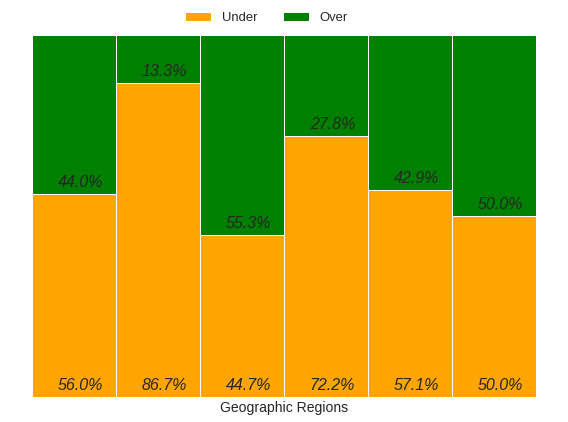

In [42]:
# XII
# Valores resumen mundiales

plt.rcParams.update({'ytick.labelleft':'off',
                    })

r = dclw['continent'].unique()

coli = ['continent', 'ind', 'LpP']
pv = dclw[coli]
pv = pv.groupby(['continent','ind']).count()
pv['%'] = pv.groupby(level=0).apply(lambda x:  100*x / x.sum())

fig= plt.figure(figsize=(8,6))

# Defino los grupos a graficar según 'over' or 'under'
overbar = pv['%'][pv.index.isin(['over'], level=1)].to_list()
underbar = pv['%'][pv.index.isin(['under'], level=1)].to_list()

# Defino parámetros del gráfico
barWidth = 1

# Create over bars
nu = plt.bar(r, underbar, color='orange', edgecolor='white', width=barWidth, label="Under")
no = plt.bar(r, overbar, bottom=underbar, color='green', edgecolor='white', width=barWidth, label="Over" )

plt.box(on=None)

# Custom x axis
plt.xticks(r, dclw['continent'].unique())
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Geographic Regions")

# Add a legend
plt.legend(ncol=2, fontsize=13, bbox_to_anchor=(0.3,0.95)) #loc='upper center', 

for n in range(6):
    plt.text(nu.patches[n].xy[0]+0.3, nu.patches[n].xy[1]+2, str(round(underbar[n],1))+'%', fontsize=16, fontstyle='oblique')
    plt.text(no.patches[n].xy[0]+0.3, no.patches[n].xy[1]+2, str(round(overbar[n],1))+'%', fontsize=16, fontstyle='oblique')

# Y axis in percentage
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)


# To fix the plot size to the layout 
plt.tight_layout()

# Show graphic
plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/HpF_bars.png')#, bbox_inches='tight')

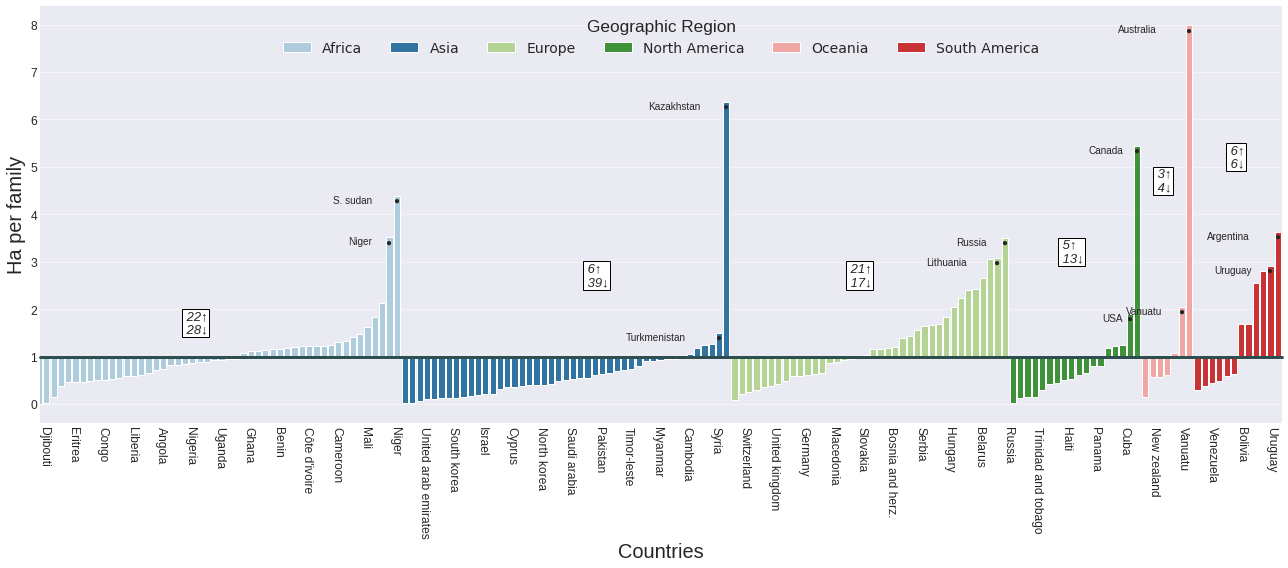

In [43]:
# XIII

# # SEABORN

plt.rcParams.update({'xtick.labelbottom':'on',
                    'ytick.labelleft':'on'})

fig= plt.figure(figsize=(18,8)) # width, height in inches -> 

with sns.axes_style("darkgrid"):
    bx = sns.barplot(x='name_w', y="ref", data=dclw, hue='continent', bottom=ref_val
                     , palette="Paired", edgecolor=None)

# Create the list of patches not nulls, for the x axis values.
def patches(bxs):
    patches_heights = []
    for n in range(len(bxs.patches)):
        if (bxs.patches[n].get_height() <0 or bxs.patches[n].get_height() >0):
            s = bxs.patches[n].get_x()
            patches_heights.append(s)
    patches_heights = pd.DataFrame(patches_heights, columns=['xaxis'])
    return(patches_heights)

pop_axis = pd.concat([dclw, patches(bx)], axis=1)

pop_axis['name_w'] = pop_axis['name_w'].replace('United states of america','USA') 

# Selection of the two first countries for every geo. region named in the plot
popg = pop_axis.groupby(['continent','name_w']).max()
popg = popg[['LpP', 'xaxis']].sort_values(by=['continent','LpP'], ascending=False)

l_pays = []
[l_pays.append(popg.loc[p][:2].index[s]) for s in range(2) for p in pop_axis['continent'].unique()]


# Function to chanche the with of the bars. Its necessary iterate over the patches values.
def change_width(bxs, new_value) : 
    for patch in bxs.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff)

width = 0.85
change_width(bx, width)

# Putting the names of the selected countrys in the plot
def text_c(df,bxs,t):
    ls = []
    if t=='mark':
        for n in l_pays:
            o = bxs.text(float(df['xaxis'][df['name_w']==n])-width, float(df['LpP'][df['name_w']==n]-0.15)
                     ,'\u25CF', fontweight='extra bold', rotation=0) #\u00B0 '\u03BF' , fontsize=30
            ls.append(o) 

    else:
        for n in l_pays:
            o = bxs.text(float(df['xaxis'][df['name_w']==n])-len(n)-1, float(df['LpP'][df['name_w']==n]-0.15)
                     ,n , rotation=0)
            ls.append(o)        
    return ls

text_c(pop_axis,bx,'mark')
text_c(pop_axis,bx,'name')


# Setting the figure 
bx.axhline(ref_val, color="darkslategray", lw=3, clip_on=False)

bx.tick_params(labelsize=12)
bx.set_xlabel("Countries", fontsize=20)
bx.set_ylabel("Ha per family", fontsize=20)

bx.set_xticklabels([bx.get_xticklabels()[n] for n in range(0,dclw.shape[0])], rotation=-90)
bx.set_xticks([bx.get_xticks()[n] for n in range(0, dclw.shape[0], 4)])

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='ultralight',
                                   style='normal', 
                                   stretch='ultra-condensed',
                                   size=14)

bx.legend(title='Geographic Region',loc= 'upper center',# bbox_to_anchor=(0.0005,1.04,1,0.1),#0.001
          frameon=False, prop=font, title_fontsize='xx-large', ncol=6)

# In order to get the values every continent
pp = pop_axis.groupby(['continent', 'ind']).count()
pp = pp.reset_index(level=['ind']).pivot(columns='ind', values='LpP')
pp['total'] = pp['over']+pp['under']
lc = [(pp.loc[n][0], pp.loc[n][1]) for n in pop_axis.continent.unique()]

def text_sum(t1, t2, x, y):
    plt.text(x, y, ' '+t1+'\u2191\n '+t2 +'\u2193',
    fontsize=13, fontstyle='oblique',
    bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='black'))

        
text_sum(str(lc[0][0]), str(lc[0][1]), 22-3, 1.5)    
text_sum(str(lc[1][0]), str(lc[1][1]), 50+39-15, 2.5)
text_sum(str(lc[2][0]), str(lc[2][1]), 50+46+17-3, 2.5)
text_sum(str(lc[3][0]), str(lc[3][1]), 50+46+38+5, 3)
text_sum(str(lc[4][0]), str(lc[4][1]), 50+46+38+18+3-3, 4.5)
text_sum(str(lc[5][0]), str(lc[5][1]), 50+46+38+18+7+6-3, 5)


plt.tight_layout()

# # Show graphic

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/ha_ref.png', bbox_inches='tight')


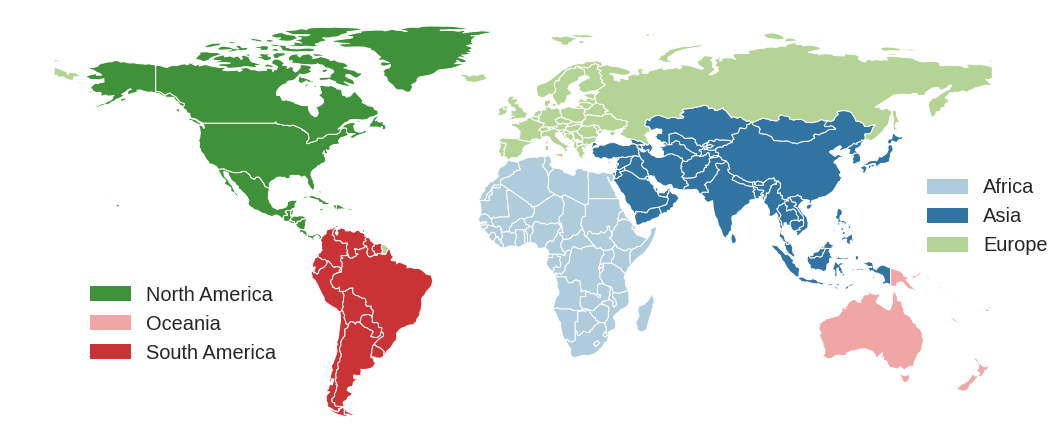

In [44]:
# XIV

# Taking the color reference of the previous plot

plt.rcParams.update({#'xtick.labelsize':15, 
                     #'ytick.labelsize':15,
                     'ytick.labelleft':'off',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False,
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     #'axes.ymargin': 0.5, 
                     #'axes.autolimit_mode': 'round_numbers',
                     #'axes.labelsize':16,
                     #'axes.grid':False,
                     #'axes.edgecolor':'slategrey'
                    })

def colors(bxs):
    patches_colors = []
    for n in range(len(bxs.patches)):
        if (bxs.patches[n].get_height() <0 or bxs.patches[n].get_height() >0):
            s = bxs.patches[n].get_facecolor()
            patches_colors.append([s])
    patches_colors = pd.DataFrame(patches_colors, columns=['color'])
    return(patches_colors)

pop_color = pd.concat([dclw, colors(bx)], axis=1)
c_list = pop_color['color'].unique()

# Creating/setting the plot
fig, cx1 = plt.subplots(1, 1, figsize=(15, 15))

pop_color = pop_color.to_crs("EPSG:4326")#3035")#"EPSG:")4326

cont_l = pop_color.continent.unique()

for c in range(len(cont_l)):
    cx1 = pop_color[pop_color["continent"] == cont_l[c]].plot(ax=cx1, color=c_list[c], 
                                        legend=True,
                                        edgecolor='white')

cx1.patch.set_facecolor('white')

## Adding the legend
patchList = []
for k in range(len(pop_color['color'].unique())):
        data_color = mpatches.Patch(color=pop_color['color'].unique()[k], 
                                  label=pop_color['continent'].unique()[k])
        patchList.append(data_color)


l1 = plt.legend(handles=patchList[3:6], ncol=1, loc='lower center', bbox_to_anchor=(0.17,0.13), fontsize=20)
l2 = plt.legend(handles=patchList[:3], ncol=1, loc='lower center', bbox_to_anchor=(0.95,0.38), fontsize=20)
plt.gca().add_artist(l1)

plt.tight_layout()

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/world_map.png', bbox_inches='tight')
plt.show()
